# Imports

First, we'll import the necessary libraries.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import datetime
import io
import zipfile
import rasterio
from rasterio.plot import show
import sklearn
from sklearn.neighbors import KernelDensity
import numpy as np
import mapclassify
import collections

# in response to an error importing collections, I used this: https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python

from collections.abc import Iterable

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

Next, we'll query the City of Philadelphia data via the ArcGIS REST API using the `requests` library. We'll also use the `json` library to parse the response.

Finally, we'll use the `geopandas` library to create a geodataframe from the response.

In [2]:
def make_api_requests(url, params):
    dfs = []
    offset = 0
    while True:
        params['resultOffset'] = offset
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data['features'])
            df = pd.concat([df.drop(['attributes'], axis=1), df['attributes'].apply(pd.Series)], axis=1)
            df['geometry'] = df['geometry'].apply(lambda x: Polygon(x['rings'][0]))
            gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:3857')
            gdf.to_crs(epsg=2272, inplace=True)

            dfs.append(gdf)
            offset += len(gdf)

            if len(gdf) < 2000:
                break
        else:
            print('Request failed with status code:', response.status_code)
            break

    return pd.concat(dfs, ignore_index=True)

We have three different datasets to import from the City's ArcGIS server. These are:

### 1. Vacant Land

In [3]:
# Define the URLs and parameters for the Vacant_Indicators_Land and Vacant_Indicators_Bldg API requests
land_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Land/FeatureServer/0/query'
land_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000
}

In [4]:
land_gdf = make_api_requests(land_url, land_params)

In [5]:
land_gdf.sample(5)

,geometry,OBJECTID,ADDRESS,OWNER1,OWNER2,BLDG_DESC,OPA_ID,LNIADDRESSKEY,COUNCILDISTRICT,ZONINGBASEDISTRICT,ZIPCODE,LAND_RANK,Shape__Area,Shape__Length
14249,"POLYGON ((2689216.916 247619.887, 2689214.974 ...",14250,1864 N TANEY ST,ADAMS DERRICK,None,VAC LAND RES < ACRE,322204700,564474,5,RSA-5,19121,0.67,118.246094,51.433574
18494,"POLYGON ((2695213.796 253030.647, 2695164.344 ...",18495,2963 N SYDENHAM ST,INDIANA OZ LLC,None,VAC LAND RES < ACRE,111177500,560157,8,RSA-5,19132,0.67,101.488281,49.865223
12706,"POLYGON ((2685223.743 240686.357, 2685156.759 ...",12707,616 N SHEDWICK ST,PHILA REDEVELOPMENT,AUTHORITY,VAC LAND RES < ACRE,242157900,533361,3,RSA-5,19104,0.67,148.605469,64.896258
5311,"POLYGON ((2714979.219 257374.943, 2714917.652 ...",5312,1919 BERKSHIRE ST,LOTIM 01 LLC,None,VAC LAND RES < ACRE,232033900,37630,7,RSA-5,19124,0.50,156.617188,67.942407
15731,"POLYGON ((2697000.272 249223.324, 2696992.466 ...",15732,1028 W ARIZONA ST,66 N DEWEY ST LLC,REVENUE STREAMS REATY LLC,ROW 2 STY MASONRY,371349000,730199,5,RM-1,19133,0.50,157.710938,61.016267


### 2. Vacant Buildings

In [6]:
bldg_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Bldg/FeatureServer/0/query'
bldg_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000
}

In [7]:
bldg_gdf = make_api_requests(bldg_url, bldg_params)

In [8]:
bldg_gdf.sample(5)

,geometry,OBJECTID,ADDRESS,OWNER1,OWNER2,BLDG_DESC,OPA_ID,LNIADDRESSKEY,COUNCILDISTRICT,ZONINGBASEDISTRICT,ZIPCODE,BUILD_RANK,Shape__Area,Shape__Length
408,"POLYGON ((2697745.977 251957.052, 2697743.582 ...",409,2839 GERMANTOWN AVE,ROOKK LLC,None,STR/OFF+APTS 3STY MASONRY,871552670,309440,5,CMX-2,19133,0.5,220.546875,82.627432
1740,"POLYGON ((2701927.695 267682.227, 2701925.341 ...",1741,5706 N 5TH ST,WILKERSON PAULINE,None,ROW W-OFF/STR 2STY MASONR,871583160,637975,9,CMX-2.5,19120,0.5,287.234375,103.979029
107,"POLYGON ((2675410.279 227646.114, 2675358.409 ...",108,6023 YOCUM ST,CMONEY REAL ESTATE COMPANY LLC,None,ROW 2 STY MASONRY,401318500,628480,2,RSA-5,19142,0.5,179.718750,71.649959
2320,"POLYGON ((2705767.189 260506.956, 2705766.526 ...",2321,4532 HURLEY ST,CANCEL AMAURY,None,ROW 2 STY MASONRY,421435500,354522,7,RSA-5,19120,0.5,212.058594,81.589232
6833,"POLYGON ((2688911.782 273450.425, 2688905.941 ...",6834,404 E UPSAL ST,ALLEN NICOLE,ALLEN TYRON,ROW B/GAR 2STY MASONRY,221084400,584441,8,RSA-5,19119,0.5,206.558594,82.187171


<Axes: >

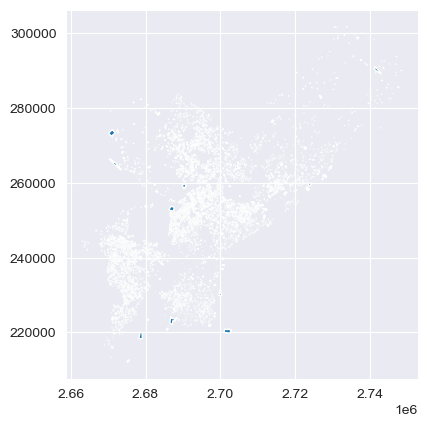

In [9]:
bldg_gdf.plot()

### Now, combine the two datasets in preparation for string cleaning.

In [10]:
columns = ['geometry', 'ADDRESS', 'BLDG_DESC',
       'OPA_ID','COUNCILDISTRICT',
       'ZIPCODE','OWNER1', 'OWNER2', 'ZONINGBASEDISTRICT']

# reduce gdfs to only the columns we want
land_gdf = land_gdf[columns]

bldg_gdf = bldg_gdf[columns]

land_gdf['type'] = 'Lot'

bldg_gdf['type'] = 'Building'

C:\Users\Nissim\AppData\Roaming\Python\Python310\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
# bind the two geodataframes together using pandas.concat
full_gdf = pd.concat([land_gdf, bldg_gdf], axis=0)

In [12]:
full_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,OWNER1,OWNER2,ZONINGBASEDISTRICT,type
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,NEWCOURTLAND ELDER SVCS,None,RSA-5,Lot
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,REDEVELOPMENT AUTHORITY,OF PHILADELPHIA,ICMX,Lot
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,REDEVELOPMENT AUTHORITY,OF PHILADELPHIA,RSA-5,Lot
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,MCHUGH JOHN,None,RSA-5,Lot
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,HERBERT MITCHELL,VICTORIA,RSA-5,Lot


### Now we'll apply string cleaning to the OWNER1 and OWNER2 columns to identify public vs. private ownership.

In [13]:
public_owners = ['PHILADELPHIA LAND BANK',
                'PHILADELPHIA HOUSING AUTH',
                'CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA',
                'DEPT OF PUBLIC PROP; CITY OF PHILA',
                'DEPT PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILA',
                'PHILA REDEVELOPMENT AUTH',
                'PHILADELPHIA LAND INVESTM',
                'REDEVELOPMENT AUTHORITY O',
                'PHILADELPHIA REDEVELOPMEN',
                'PHILA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING',
                'PHILA REDEVELOPMENT AUTHO',
                'DEPT OF PUB PROP; CITY OF PHILA',
                'PHILA HOUSING DEV CORP',
                'DEP OF PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY',
                'COMMONWEALTH OF PA',
                'COMMONWEALTH OF PENNA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA',
                'PUBLIC PROP DIV; CITY OF PHILA',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                'REAL ESTATE DIV; CITY OF PHILA',
                'REAL ESTATE DIVISION; CITY OF PHILA',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING'
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMENT AUTH',
                'PHILADELPHIA HOUSING AUTHORITY',
                'PHILADELPHIA LAND BANK',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHORITY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PENNSYLVANIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PENNDOT'
]

# return unique public_owners
public_owners = list(set(public_owners))

In [14]:
# create a new column that combines the OWNER1 and OWNER2 columns according to the following rules:
# if OWNER1 is not null and OWNER2 is null, then the new column is OWNER1
# if OWNER1 is null and OWNER2 is not null, then the new column is OWNER2
# if OWNER2 starts with a preposition, then the new column is OWNER1 + OWNER2 separated by a space
# if OWNER2 does not start with a preposition, then the new column is OWNER2 + OWNER1 separated by a se


# define a function to check if a string starts with a preposition
def starts_with_preposition(string):
    prepositions = ['a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'from', 'in', 'into', 'nor', 'of', 'on', 'or', 'so', 'the', 'to', 'up', 'yet']
    if string.split(' ')[0].lower() in prepositions:
        return True
    else:
        return False
    
# define a function to combine the OWNER1 and OWNER2 columns
def combine_owners(row):
    if pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return None
    elif pd.isnull(row['OWNER1']) and not pd.isnull(row['OWNER2']):
        return row['OWNER2']
    elif not pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return row['OWNER1']
    elif starts_with_preposition(row['OWNER2']):
        return row['OWNER1'] + ' ' + row['OWNER2']
    else:
        return row['OWNER2'] + '; ' + row['OWNER1']
    
# apply the combine_owners function to the full_gdf dataframe
full_gdf['OWNER'] = full_gdf.apply(combine_owners, axis=1)

# if OWNER is 'PHILADELPHIA HOUSING AUTH' or 'PHILA HOUSING AUTHORITY', replace with 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILADELPHIA HOUSING AUTH', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING AUTHORITY', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'

# redevelopment authority typos
redev_owner_variations = ['REDEVELOPMENT AUTHORITY OF PHILA', 'PHILA REDEVELOPMENT AUTH',
'REDEVELOPMENT AUTHORITY O', 'PHILADELPHIA REDEVELOPMEN',
'PHILA REDEVELOPMENT AUTHO', 'REDEVELOPMENT AUTHORITY',
'REDEVELOPMENT AUTH']

for var in redev_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA'

# department of public property typos
dpp_owner_variations = ['DEPT OF PUBLIC PROPERTY', 'DEPT OF PUBLIC PROPERT', 'DEPT OF PUBLC PROP; CITY OF PHILA',
                        'DEPT OF PUBLIC PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROPERTY; CITY OF PHILA', 'DEPT PUB PROP; CITY OF PHILA',
                        'DEPT OF PUB PROP; CITY OF PHILA', 'DEP OF PUB PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                        'DEPT PUBLIC PROP R E DIV; CITY OF PHILA', 'PUBLIC PROP DIV; CITY OF PHILA', 'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                        'REAL ESTATE DIV; CITY OF PHILA', 'REAL ESTATE DIVISION; CITY OF PHILA']

for var in dpp_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY'

# HUD
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'

# commonwealth of pennsylvania
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PENNA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'

# phdc
full_gdf.loc[full_gdf['OWNER'] == 'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING DEV CORP', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'

# PennDOT
full_gdf.loc[full_gdf['OWNER'] == 'DEPARTMENT OF TRANSPORTAT; COMMONWEALTH OF PENNSYLVA', 'OWNER'] = 'PENNDOT'

# city of Philadelphia
full_gdf.loc[full_gdf['OWNER'] == 'CITY OF PHILADELPHIA', 'OWNER'] = 'CITY OF PHILA'

# create a new column called 'public_owner' that is True if the OWNER column is in the public_owners list
full_gdf['public_owner'] = full_gdf['OWNER'].isin(public_owners)

# drop the OWNER1 and OWNER2 columns
full_gdf = full_gdf.drop(['OWNER1', 'OWNER2'], axis=1)

In [15]:
# randomly sample ten rows from the full_gdf dataframe
full_gdf.sample(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner
4379,"POLYGON ((2700752.437 251864.194, 2700743.792 ...",255 W CAMBRIA ST,VAC LAND IND < ACRE,885263120,7,19133,RSA-5,Lot,PHILA AUTH IND DEV,False
15607,"POLYGON ((2700425.738 255503.855, 2700440.172 ...",3531 N 5TH ST,VAC LAND COMM. < ACRE,885104900,7,19140,RM-1,Lot,CANCEL MARC ANTHONY,False
24847,"POLYGON ((2700703.104 248474.464, 2700747.239 ...",2307 1/2 N PHILIP ST,VAC LAND RES < ACRE,191150800,7,19133,RSA-5,Lot,BROWN EDITH,False
7000,"POLYGON ((2696984.083 277184.929, 2696975.114 ...",1840 ELSTON ST,ROW B/GAR 2STY MASONRY,101326800,9,19126,RSA-5,Building,HOLMES-OBERRY VALERIE TIN; HOLMES VALERRA TINA,False
9160,"POLYGON ((2689311.253 261835.528, 2689228.738 ...",5216 LAURENS ST,VAC LAND RES < ACRE,123240500,8,19144,RSA-3,Lot,KING MARY T,False
13266,"POLYGON ((2688145.129 246645.648, 2688135.104 ...",2838 CECIL B MOORE AVE,VAC LAND RES < ACRE,324041801,5,19121,RM-1,Lot,CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROP...,True
1322,"POLYGON ((2698700.456 248996.074, 2698702.717 ...",2342 N 6TH ST,VAC LAND COMM. < ACRE,885428060,5,19133,CMX-2,Lot,ODELLIE MICKENS OF RT; FRANK GAYMON,False
17208,"POLYGON ((2687003.827 249637.781, 2686993.197 ...",3210 W SUSQUEHANNA AVE,ROW 3 STY MASONRY,323169200,5,19121,RSA-5,Lot,BLOCKER ROZENA,False
2550,"POLYGON ((2688875.422 245612.519, 2688889.291 ...",2637 JEFFERSON ST,VAC LAND RES < ACRE,291195000,5,19121,RM-1,Lot,HARRISON INC,False
23523,"POLYGON ((2683004.640 241116.161, 2683001.433 ...",3904 FOLSOM ST,VAC LAND RES < ACRE,243054710,3,19104,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True


### 3. PHS LandCare Parcels

Now we can import the PHS Community and Philadelphia LandCare parcels and spatially join them to our full_gdf, which contains all of the vacant parcels in the city (both lots and buildings).

(Note that Community LandCare parcels are taken care of by community groups, while LandCare parcels are taken care of by PHS. There are roughly three times as many Philadelphia LandCare parcels as Community LandCare parcels.)

In [16]:
def make_landcare_api_requests(url, params):
    dfs = []
    offset = 0
    while True:
        params['resultOffset'] = offset
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data['features'])
            df = pd.concat([df.drop(['attributes'], axis=1), df['attributes'].apply(pd.Series)], axis=1)
            df['geometry'] = df['geometry'].apply(lambda x: Polygon(x['rings'][0]))
            gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:2272')
          #  gdf.to_crs(epsg=2272, inplace=True)

            dfs.append(gdf)
            offset += len(gdf)

            if len(gdf) < 2000:
                break
        else:
            print('Request failed with status code:', response.status_code)
            break

    return pd.concat(dfs, ignore_index=True)

In [17]:
# Define the URL for the PHS_CommunityLandcare feature service
phs_landcare_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_CommunityLandcare/FeatureServer/0/query'

# Define the parameters for the PHS_CommunityLandcare API request
phs_landcare_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

In [18]:
# Concatenate the dataframes into a single geodataframe
phs_landcare_gdf = make_landcare_api_requests(phs_landcare_url, phs_landcare_params)

phs_cols = ['ADDRESS', 'COMM_PARTN']

phs_landcare_gdf = phs_landcare_gdf[phs_cols]

In [19]:
# Define the URL for the PHS_PhilaLandCare_Maintenance feature service
phs_maintenance_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_PhilaLandCare_Maintenance/FeatureServer/0/query'

# Define the parameters for the PHS_PhilaLandCare_Maintenance API request
phs_maintenance_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

In [20]:
# Concatenate the dataframes into a single geodataframe
phs_maintenance_gdf = make_landcare_api_requests(phs_maintenance_url, phs_maintenance_params)

In [21]:
# add a column called 'COMM_PARTN' to phs_maintenance_gdf
phs_maintenance_gdf['COMM_PARTN'] = 'PHS'

phs_maintenance_gdf.head()

,geometry,OBJECTID,TENCODE,ADDRESS,OWNER1,OWNER2,BLDG_CODE,BLDG_DESC,BRT_ID,GROSS_AREA,...,TARGETAREA,GROUP_,GRID,CCD,CCD_PERSON,ADDR_RANGE,ZIPCODE,Shape__Area,Shape__Length,COMM_PARTN
0,"POLYGON ((2698543.053 248810.880, 2698461.617 ...",1,5386002312,2312 N MARSHALL ST,PHILA REDEVELOPMENT AUTH,,SR,VAC LAND RES < ACRE,371049900,1273,...,Eastern North,None,278,5,Darrell L. Clarke,2310-2316 MARSHALL STREET,19133,1279.597046,195.672676,PHS
1,"POLYGON ((2698348.950 248755.805, 2698438.297 ...",2,8793002301,2301-03 N 07TH ST,CITY OF PHILA,,SC,VAC LAND COMM. < ACRE,886810561,3067,...,Eastern North,None,278,5,Darrell L. Clarke,2303 N 7TH STREET,19133,3170.937927,245.624697,PHS
2,"POLYGON ((2697845.668 247251.060, 2697771.775 ...",3,8795002027,2027 N 08TH ST,COMET HOMES INC,,SR,VAC LAND RES < ACRE,202097400,1147,...,Eastern North,None,278,5,Darrell L. Clarke,2027 N 8TH STREET,19122,1137.090088,179.889029,PHS
3,"POLYGON ((2688454.415 245375.389, 2688452.637 ...",4,8834001439,1439 N 28TH ST,HARRISON INC,,SR,VAC LAND RES < ACRE,292094500,999,...,North Central,None,290,5,Darrell L. Clarke,1439-41 N 28TH ST,19121,992.503540,171.520004,PHS
4,"POLYGON ((2698334.739 246135.996, 2698332.737 ...",5,5386001825,1825 N MARSHALL ST,CITY OF PHILA,,SR,VAC LAND RES < ACRE,201131201,905,...,Eastern North,None,292,5,Darrell L. Clarke,1821-1827 N MARSHALL STREET,19122,935.317322,148.531771,PHS


In [22]:
# Select the columns of interest
phs_maintenance_cols = ['ADDRESS', 'COMM_PARTN']
phs_maintenance_gdf = phs_maintenance_gdf[phs_maintenance_cols]

In [23]:
phs_gdf = pd.concat([phs_maintenance_gdf, phs_landcare_gdf], ignore_index=True)

In [24]:
phs_gdf.sample(10)

,ADDRESS,COMM_PARTN
967,2600 REED ST,PHS
8130,3229 N 15TH ST,Tioga United
1751,4203 LEIDY AVE,PHS
7139,2238 N 30TH ST,SMCDC
3220,2611 N 27TH ST,PHS
8104,2040 N 32ND ST,SMCDC
8525,733 MASTER ST,SKCP
4378,2716 N LAWRENCE ST,PHS
2251,755 N 44TH ST,PHS
6459,440 W NORRIS ST,PHS


In [25]:
# spatially join phs_landcare_gdf to full_gdf
# joined_gdf = gpd.sjoin(full_gdf, phs_gdf, how='left', predicate='intersects')

joined_gdf = full_gdf.merge(phs_gdf, how='left', on='ADDRESS')

In [26]:
joined_gdf['COMM_PARTN'] = joined_gdf['COMM_PARTN'].fillna("None")

In [27]:
joined_gdf.sample(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN
19362,"POLYGON ((2696222.625 252275.592, 2696218.000 ...",1315 W WILLIAM ST,VAC LAND RES < ACRE,372370500,5,19132,RM-1,Lot,STABLE GENIUS LLC,False,None
24622,"POLYGON ((2715286.418 259291.295, 2715303.347 ...",1665 ORTHODOX ST,VAC LAND RES < ACRE,232100500,7,19124,RM-1,Lot,ZWICK PROPERTIES LLC,False,None
7908,"POLYGON ((2688491.892 268860.573, 2688483.508 ...",52 E PASTORIUS ST,VAC LAND RES < ACRE,592000009,8,19144,RSA-5,Lot,MATYANOR LLC,False,None
24682,"POLYGON ((2697791.230 268680.105, 2697560.856 ...",1419 W GRANGE AVE,VAC LAND COMM. < ACRE,881076300,8,19141,CMX-2,Lot,GRANGE DEVELOPMENT LLC,False,None
26815,"POLYGON ((2689081.844 230414.678, 2689079.761 ...",1229 S 22ND ST,ROW 2 STY MASONRY,361218600,2,19146,RSA-5,Building,BROWN ELIZABETH; BROWN RONALD ISAAC,False,None
14449,"POLYGON ((2690060.891 229962.416, 2690053.607 ...",1932 TITAN ST,VAC LAND RES < ACRE,361100115,2,19146,RSA-5,Lot,PHILADELPHIA LAND BANK,True,None
21173,"POLYGON ((2676564.488 240509.270, 2676550.060 ...",5144 FUNSTON ST,VAC LAND RES < ACRE,441283610,3,19139,RSA-5,Lot,WE BUY CITY HOMES INC,False,MoMC
23553,"POLYGON ((2668825.523 214109.913, 2668873.839 ...",2718 S 86TH ST,VAC LAND RES < ACRE,405061036,2,19153,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
7266,"POLYGON ((2692936.616 264052.937, 2692929.807 ...",4931 GERMANTOWN AVE,VAC LAND COMM. < ACRE,885123100,8,19144,CMX-2.5,Lot,SEITAJ BRIGET,False,None
22768,"POLYGON ((2691063.047 229097.293, 2691061.069 ...",1413 S COLORADO ST,ROW 3 STY MASONRY,365215000,2,19146,RSA-5,Lot,BOODY ELISA; BELKOWSKI MARK A,False,None


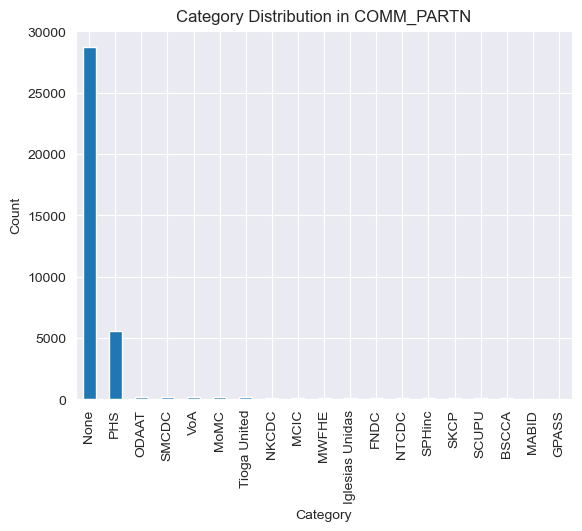

In [28]:
import matplotlib.pyplot as plt

# Count the occurrences of each category in the COMM_PARTN column
category_counts = joined_gdf['COMM_PARTN'].value_counts()

# Create a bar chart
category_counts.plot(kind='bar')

# Set the chart title and axis labels
plt.title('Category Distribution in COMM_PARTN')
plt.xlabel('Category')
plt.ylabel('Count')

# Display the chart
plt.show()

In [29]:
joined_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,RSA-5,Lot,NEWCOURTLAND ELDER SVCS,False,None
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,RSA-5,Lot,MCHUGH JOHN,False,None
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,RSA-5,Lot,VICTORIA; HERBERT MITCHELL,False,None


In [30]:
# return the number of rows in joined_gdf where COMM_PARTN is not None
len(joined_gdf[joined_gdf['COMM_PARTN'] != 'None'])

7315

In [31]:
# return the first five rows of joined_gdf where COMM_PARTN is not None
joined_gdf[joined_gdf['COMM_PARTN'] != 'None'].head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS
8,"POLYGON ((2671363.932 240660.448, 2671409.874 ...",252 N 61ST ST,ROW 2 STY MASONRY,341145900,4,19139,RM-1,Lot,CITY BLOCK ACQUISITION XI,False,PHS
12,"POLYGON ((2692912.046 249149.713, 2692909.862 ...",2233 N UBER ST,VAC LAND RES < ACRE,162113701,5,19132,RSA-5,Lot,CITY OF PHILA,True,SCUPU
14,"POLYGON ((2675321.835 238410.298, 2675306.316 ...",5332 MARKET ST,VAC LAND COMM. < ACRE,885607760,3,19139,CMX-2,Lot,NEIGHBORHOOD RESTORATION,False,PHS
21,"POLYGON ((2702604.971 251022.145, 2702603.181 ...",2802 N WATER ST,VAC LAND RES < ACRE,071335000,7,19134,RSA-5,Lot,PHILLY HOME BUILDERS,False,Iglesias Unidas


In [32]:
joined_gdf.columns

Index(['geometry', 'ADDRESS', 'BLDG_DESC', 'OPA_ID', 'COUNCILDISTRICT',
       'ZIPCODE', 'ZONINGBASEDISTRICT', 'type', 'OWNER', 'public_owner',
       'COMM_PARTN'],
      dtype='object')

Now we need to import two more datasets from the City's Carto database (SQL).

In [33]:
import datetime

def get_data(sql_query):
    response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": sql_query})
    data = response.json()["rows"]
    df = pd.DataFrame(data)
    return df

# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

### 1. L&I Complaints

In [34]:
complaints_sql_query = "SELECT address, service_request_id, subject, status, service_name, service_code FROM public_cases_fc WHERE requested_datetime >= '{}'".format(one_year_ago)

complaints_df = get_data(complaints_sql_query)

In [35]:
complaints_count_df = complaints_df.groupby('address').agg(
    all_complaints_past_year=('service_request_id', 'count'),
    open_complaints_past_year=('status', lambda x: sum(status.lower() == 'open' for status in x))
).reset_index()

complaints_count_df['open_complaints_past_year'] = complaints_count_df['open_complaints_past_year'].astype(int)

In [36]:
complaints_count_df.sample(10)

,address,all_complaints_past_year,open_complaints_past_year
28607,1836 WILDER ST,5,0
100564,5930 CATHARINE ST,3,2
98451,5747 N 13TH ST,5,1
75874,4136 OGDEN ST,2,1
53859,2700 BOUDINOT ST,5,0
24662,1717 FOULKROD ST,4,0
27206,1812 GILLINGHAM ST,1,0
114534,718 ADAMS AVE,2,1
369,1000 W GIRARD AVE,7,1
34702,2028 E ALLEGHENY AVE,1,0


### 2. L&I Code Violations

In [37]:
# Create the SQL query
violations_sql_query = "SELECT parcel_id_num, casenumber, casecreateddate, casetype, casestatus, violationnumber, violationcodetitle, violationstatus, opa_account_num, address, opa_owner, geocode_x, geocode_y FROM violations WHERE violationdate >= '{}'".format(one_year_ago)

violations_df = get_data(violations_sql_query)

In [38]:
violations_count_df = violations_df.groupby('address').agg(
    all_violations_past_year=('violationnumber', 'count'),
    open_violations_past_year=('violationstatus', lambda x: sum(status.lower() == 'open' for status in x))
).reset_index()

violations_count_df['open_violations_past_year'] = violations_count_df['open_violations_past_year'].astype(int)

In [39]:
violations_count_df.sample(5)

,address,all_violations_past_year,open_violations_past_year
18476,3751 N PERCY ST,6,6
24388,5337 PULASKI AVE,4,4
9086,2116 EARP ST,11,6
25896,5731 MARKET ST,16,8
34133,993 SANGER ST,1,0


In [40]:
joined_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,RSA-5,Lot,NEWCOURTLAND ELDER SVCS,False,None
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,RSA-5,Lot,MCHUGH JOHN,False,None
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,RSA-5,Lot,VICTORIA; HERBERT MITCHELL,False,None


In [41]:
joined_gdf = joined_gdf.merge(complaints_count_df, how='left', left_on='ADDRESS', right_on='address')

In [42]:
joined_gdf = joined_gdf.drop('address', axis=1)

In [43]:
joined_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN,all_complaints_past_year,open_complaints_past_year
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,RSA-5,Lot,NEWCOURTLAND ELDER SVCS,False,None,3.0,0.0
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS,NaN,NaN
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,RSA-5,Lot,MCHUGH JOHN,False,None,NaN,NaN
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,RSA-5,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN


In [44]:
joined_gdf = joined_gdf.merge(violations_count_df, how='left', left_on='ADDRESS', right_on='address')

In [45]:
joined_gdf = joined_gdf.drop('address', axis=1)

In [46]:
joined_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN,all_complaints_past_year,open_complaints_past_year,all_violations_past_year,open_violations_past_year
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,RSA-5,Lot,NEWCOURTLAND ELDER SVCS,False,None,3.0,0.0,NaN,NaN
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS,NaN,NaN,NaN,NaN
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,NaN,NaN
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,RSA-5,Lot,MCHUGH JOHN,False,None,NaN,NaN,NaN,NaN
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,RSA-5,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,2.0,0.0


### Next, we'll add a centroids column to the joined_gdf in order to make it easier to cleanly join neighborhoods, RCOs, tree canopy, and guncrime data.

Joining by points rather than polygons makes it far less likely that a point straddles two polygons, which make the join ambiguous and potentially incorrect.

In [47]:
# add a column for centroids geometry to use for joins and to extrct raster values
joined_gdf['centroid'] = joined_gdf['geometry'].centroid

# create a geodata of polygon geoms and opa_id
poly_gdf = joined_gdf[['OPA_ID', 'geometry']]

# drop the 'geometry' column from joined_gdf
joined_gdf.drop(['geometry'], axis=1, inplace=True)

# set the 'centroid' column as the geometry column
joined_gdf.set_geometry('centroid', inplace=True)

### Import Philadelphia's Neighborhoods from Azavea

In [48]:
hoods_url = 'https://github.com/azavea/geo-data/raw/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.zip'

hoods_response = requests.get(hoods_url)

with io.BytesIO(hoods_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
hoods = gpd.read_file("path/to/destination/folder/Neighborhoods_Philadelphia.shp")

hoods = hoods.to_crs(epsg=2272)

In [49]:
joined_gdf = gpd.sjoin(joined_gdf, hoods, how='left', predicate='intersects')

joined_gdf = joined_gdf.drop(['index_right', 'NAME', 'LISTNAME', 'Shape_Leng', 'Shape_Area'], axis=1)

joined_gdf.rename(columns={'MAPNAME': 'neighborhood'}, inplace=True)

### Import RCOs from the City

In [50]:
# Define the URL for the RCOs feature service
rcos_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Zoning_RCO/FeatureServer/0/query'

# Define the parameters for the RCOs API request
rcos_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

In [51]:
# Convert the pandas dataframe to a geopandas geodataframe
rcos_gdf = make_api_requests(rcos_url, rcos_params)

# Select columns and convert 'PRIMARY_PHONE' and 'EXPIRATIONYEAR' to strings
rcos_gdf = rcos_gdf[['geometry', 'ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE']]
rcos_gdf['PRIMARY_PHONE'] = rcos_gdf['PRIMARY_PHONE'].astype(str)

# Lowercase column names
rcos_gdf.columns = rcos_gdf.columns.str.lower()

# Spatially join rcos_gdf to joined_gdf
w_rcos_gdf = gpd.sjoin(joined_gdf, rcos_gdf, how='left', predicate='within')

# Drop the 'index_right' column and remove duplicates by 'OPA_ID'
w_rcos_gdf = w_rcos_gdf.drop('index_right', axis=1).drop_duplicates(subset='OPA_ID')

w_rcos_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN,all_complaints_past_year,open_complaints_past_year,all_violations_past_year,open_violations_past_year,centroid,neighborhood,organization_name,organization_address,primary_email,primary_phone
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,RSA-5,Lot,NEWCOURTLAND ELDER SVCS,False,None,3.0,0.0,NaN,NaN,POINT (2687670.823 256881.851),Allegheny West,East Falls Community Council,"PO Box 12672, 19129",hilary.j.langer@gmail.com,2156034279
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS,NaN,NaN,NaN,NaN,POINT (2675594.984 242079.100),Haddington,Parkside Association,"Parkside Evans Recreation Center, 53rd & Parks...",lhudson@parksideassociation.org,2158699752
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,NaN,NaN,POINT (2694579.985 249997.339),Stanton,Uptown Entertainment and Development Corporation,"2227 N. Broad St. 2nd Floor\r\nPhiladelphia, P...",uedc.rco@gmail.com,9083341793
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,RSA-5,Lot,MCHUGH JOHN,False,None,NaN,NaN,NaN,NaN,POINT (2699242.101 246724.058),West Kensington,Zulu Nation RCO,"2045 N Lawrence Street\r\nPhiladelphia, PA 19133",zulunationcdc@gmail.com,2155205686
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,RSA-5,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,2.0,0.0,POINT (2695051.365 251709.399),Stanton,"Tioga United, Inc.","1539 W. Venango Street \r\nPhiladelphia, PA 19140",tiogaunitedrco@gmail.com,2152397471


### Finally, tree canopy data.

In [52]:
tree_url = 'https://national-tes-data-share.s3.amazonaws.com/national_tes_share/pa.zip.zip'

tree_response = requests.get(tree_url)

with io.BytesIO(tree_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
pa = gpd.read_file("path/to/destination/folder/pa.shp")

pa = pa.to_crs(epsg=2272)

phl = pa[pa['county'] == 'Philadelphia County']

tree_cols = ['tc_gap', 'geometry']

phl = phl[tree_cols]

phl.rename(columns={'tc_gap': 'tree_canopy_gap'}, inplace=True)

phl.head()

,tree_canopy_gap,geometry
5395,0.216832,"POLYGON ((2698038.313 234970.868, 2697586.173 ..."
5396,0.196093,"POLYGON ((2699640.691 237442.051, 2699638.100 ..."
5397,0.297005,"POLYGON ((2696855.043 237339.498, 2696827.290 ..."
5398,0.346134,"POLYGON ((2693798.320 238055.129, 2693725.464 ..."
5399,0.097603,"POLYGON ((2689575.081 237146.348, 2689561.703 ..."


In [54]:
# spatially join phl to joined_gdf
w_rcos_gdf = gpd.sjoin(w_rcos_gdf, phl, how='left', predicate='intersects')

w_rcos_gdf = w_rcos_gdf.drop(['index_right'], axis=1)

# drop duplicate opa_ids
w_rcos_gdf = w_rcos_gdf.drop_duplicates(subset='OPA_ID')

In [55]:
w_rcos_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,ZONINGBASEDISTRICT,type,OWNER,public_owner,COMM_PARTN,...,open_complaints_past_year,all_violations_past_year,open_violations_past_year,centroid,neighborhood,organization_name,organization_address,primary_email,primary_phone,tree_canopy_gap
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,RSA-5,Lot,NEWCOURTLAND ELDER SVCS,False,None,...,0.0,NaN,NaN,POINT (2687670.823 256881.851),Allegheny West,East Falls Community Council,"PO Box 12672, 19129",hilary.j.langer@gmail.com,2156034279,0.230223
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,ICMX,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,PHS,...,NaN,NaN,NaN,POINT (2675594.984 242079.100),Haddington,Parkside Association,"Parkside Evans Recreation Center, 53rd & Parks...",lhudson@parksideassociation.org,2158699752,0.104381
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,RSA-5,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,...,NaN,NaN,NaN,POINT (2694579.985 249997.339),Stanton,Uptown Entertainment and Development Corporation,"2227 N. Broad St. 2nd Floor\r\nPhiladelphia, P...",uedc.rco@gmail.com,9083341793,0.165151
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,RSA-5,Lot,MCHUGH JOHN,False,None,...,NaN,NaN,NaN,POINT (2699242.101 246724.058),West Kensington,Zulu Nation RCO,"2045 N Lawrence Street\r\nPhiladelphia, PA 19133",zulunationcdc@gmail.com,2155205686,0.199069
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,RSA-5,Lot,VICTORIA; HERBERT MITCHELL,False,None,...,NaN,2.0,0.0,POINT (2695051.365 251709.399),Stanton,"Tioga United, Inc.","1539 W. Venango Street \r\nPhiladelphia, PA 19140",tiogaunitedrco@gmail.com,2152397471,0.327281


# Gun Crimes

For our gun crime kernel density estimate, we have two steps:

### 1. Import gun crime data from the City's Carto database (SQL):

In [62]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
from matplotlib import pyplot as plt
from rasterio.plot import show


# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Modify the SQL query
guncrime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Aggravated Assault Firearm', 'Robbery Firearm')".format(one_year_ago)

# Make the GET request
guncrime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrime_sql_query})

# Get the data
guncrime_data = guncrime_response.json()["rows"]

# convert guncrime_data to a pandas dataframe
guncrime_df = pd.DataFrame(guncrime_data)

# drop null geometry values
guncrime_df = guncrime_df[guncrime_df['point_x'].notnull()]
guncrime_df = guncrime_df[guncrime_df['point_y'].notnull()]

# Convert the data to a geopandas dataframe
guncrime_gdf = gpd.GeoDataFrame(guncrime_df, geometry=gpd.points_from_xy(guncrime_df.point_x, guncrime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
guncrime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
guncrime_gdf.to_crs(epsg=2272, inplace=True)

In [63]:
guncrime_gdf.head()

,text_general_code,dispatch_date,geometry
0,Aggravated Assault Firearm,2023-03-11,POINT (2701499.991 254527.321)
1,Aggravated Assault Firearm,2023-02-26,POINT (2687640.511 228770.118)
2,Aggravated Assault Firearm,2023-02-26,POINT (2713880.884 277084.477)
3,Aggravated Assault Firearm,2023-03-11,POINT (2693641.638 272700.071)
4,Robbery Firearm,2023-02-22,POINT (2686795.954 250843.724)


In [64]:
guncrime_gdf.shape

(6022, 3)

### 2. Create a kernel density estimate from the gun crime data:

Note that, rather than following the one mile bandwidth used in the original research, I'm using an adaptive bandwidth based on Silverman's rule to account for varying local densities. Silverman's is more robust than Scott's method as well. I'm implementing this in scipy's gaussian_kde function.

\Silverman, B., 1986. Density estimation for statistic and data analysis. London, UK: Chapman and Hall. https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf.

Note that ArcGIS Pro implements Silverman's Rule of Thumb: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-kernel-density-works.htm

However, I really need to look into this more to make sure that I've implemented it correctly. The distribution of my data is non-parametric, meaning that neither Scott's nor Silverman's methods are appropriate.

In [83]:
import rasterio
from rasterio.transform import from_origin
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy import stats
import pandas as pd


def compute_adaptive_bandwidth(data, initial_bandwidth):
    """
    This function computes the adaptive bandwidth based on initial KDE.
    """
    # Step 1: Compute a KDE with a fixed bandwidth
    kde_skl = KernelDensity(bandwidth=initial_bandwidth)
    kde_skl.fit(data)

    # Step 2: Compute the densities
    density = np.exp(kde_skl.score_samples(data))

    # Step 3: Compute the adaptive bandwidth
    adaptive_bandwidth = initial_bandwidth * (1/density)**(0.5)

    return adaptive_bandwidth

In [65]:
def adaptive_kde_partition_to_raster(data, extent_data, initial_bandwidth, ngroups=None, raster_file='kde.tif', resolution=100):
    """
    This function computes the KDE with adaptive bandwidth using partitioning and save the density to a raster file.
    The extent and resolution of the output raster is determined by the extent_data.
    """
    # Step 1: Compute the adaptive bandwidth
    adaptive_bandwidth = compute_adaptive_bandwidth(data, initial_bandwidth)

    # Add small random noise to the bandwidth values
    adaptive_bandwidth += np.random.uniform(-0.01, 0.01, size=len(adaptive_bandwidth))

    # Step 2: Partition the data into groups
    if ngroups is None:
        ngroups = int(np.sqrt(len(data)))

    # Create a DataFrame for easier data manipulation
    df = pd.DataFrame(data, columns=['x', 'y'])
    df['bw'] = adaptive_bandwidth

    # Create the partitions
    df['group'] = pd.qcut(df['bw'], q=ngroups, labels=False)

    # Define the grid
    min_x, min_y, max_x, max_y = extent_data['x'].min(), extent_data['y'].min(), extent_data['x'].max(), extent_data['y'].max()
    x_grid, y_grid = np.mgrid[min_x:max_x:complex(0, resolution), min_y:max_y:complex(0, resolution)]

    # Step 3: Compute the KDE for each group and accumulate the density on the grid
    density = np.zeros(x_grid.shape)
    for group in df['group'].unique():
        group_data = df[df['group'] == group][['x', 'y']]
        group_bw = df[df['group'] == group]['bw'].mean()

        kde_skl = KernelDensity(bandwidth=group_bw)
        kde_skl.fit(group_data)

        # Evaluate the KDE on the grid and add to the accumulated density
        grid_positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
        group_density = np.exp(kde_skl.score_samples(grid_positions.T))
        density += group_density.reshape(x_grid.shape)

    # Step 4: Save the density to a raster file
    transform = from_origin(min_x, max_y, (max_x - min_x) / resolution, (max_y - min_y) / resolution)
    new_dataset = rasterio.open(raster_file, 'w', driver='GTiff',
                                height = density.shape[0],
                                width = density.shape[1],
                                count=1, dtype=str(density.dtype),
                                crs='EPSG:2272',
                                transform=transform)
    new_dataset.write(density, 1)
    new_dataset.close()

In [84]:
# Extract x and y coordinates from the geometry column
guncrime_gdf['x'] = guncrime_gdf.geometry.x
guncrime_gdf['y'] = guncrime_gdf.geometry.y

# Select only the x and y columns
guncrime_coords = pd.DataFrame(guncrime_gdf[['x', 'y']].values)

guncrime_coords = guncrime_coords.rename(columns={0: 'x', 1: 'y'})

# Extract x and y coordinates from the geometry column
w_rcos_gdf['x'] = w_rcos_gdf.geometry.x
w_rcos_gdf['y'] = w_rcos_gdf.geometry.y

# Select only the x and y columns
w_rcos_coords = pd.DataFrame(w_rcos_gdf[['x', 'y']].values)

w_rcos_coords = w_rcos_coords.rename(columns={0: 'x', 1: 'y'})

In [85]:
adaptive_kde_partition_to_raster(
    data=guncrime_coords,
    extent_data=w_rcos_coords,
    initial_bandwidth=0.1,
    raster_file="adaptive_bw_test_rast.tif",
    resolution=100
)

C:\Users\Nissim\.conda\envs\vacant-lots-proj\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\Nissim\.conda\envs\vacant-lots-proj\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\Nissim\.conda\envs\vacant-lots-proj\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\Nissim\.conda\envs\vacant-lots-proj\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\Nissim\.conda\envs\vacant-lots-proj\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Us

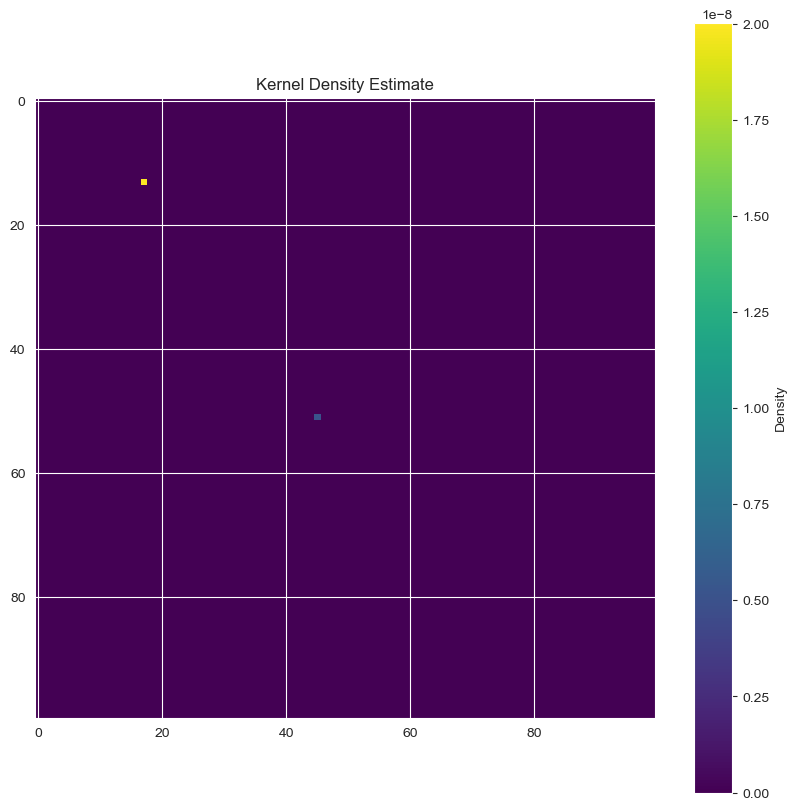

In [86]:
import rasterio
import matplotlib.pyplot as plt

# Open the file:
raster = rasterio.open('adaptive_bw_test_rast.tif')

# Read the grid values into numpy array (note that this is how you access the data in rasterio)
array = raster.read(1)

# Plot the grid
plt.figure(figsize=(10,10))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Density')
plt.title('Kernel Density Estimate')
plt.show()

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy import stats
import pandas as pd


def compute_adaptive_bandwidth(data, initial_bandwidth):
    """
    This function computes the adaptive bandwidth based on initial KDE.
    """
    # Step 1: Compute a KDE with a fixed bandwidth
    kde_skl = KernelDensity(bandwidth=initial_bandwidth)
    kde_skl.fit(data)

    # Step 2: Compute the densities
    density = np.exp(kde_skl.score_samples(data))

    # Step 3: Compute the adaptive bandwidth
    adaptive_bandwidth = initial_bandwidth * (1/density)**(0.5)

    return adaptive_bandwidth

In [ ]:
def adaptive_kde_partition(data, initial_bandwidth, ngroups=None, resolution=50):
    """
    This function computes the KDE with adaptive bandwidth using partitioning and returns a 2D density grid.
    """
    # Step 1: Compute the adaptive bandwidth
    adaptive_bandwidth = compute_adaptive_bandwidth(data, initial_bandwidth)

    # Add small random noise to the bandwidth values
    adaptive_bandwidth += np.random.uniform(-0.01, 0.01, size=len(adaptive_bandwidth))

    # Step 2: Partition the data into groups
    if ngroups is None:
        ngroups = int(np.sqrt(len(data)))

    # Create a DataFrame for easier data manipulation
    df = pd.DataFrame(data, columns=['x', 'y'])
    df['bw'] = adaptive_bandwidth

    # Create the partitions
    df['group'] = pd.qcut(df['bw'], q=ngroups, labels=False)

    # Step 3: Compute the KDE for each group and store the density in the DataFrame
    xmin, ymin, xmax, ymax = np.min(data[:, 0]), np.min(data[:, 1]), np.max(data[:, 0]), np.max(data[:, 1])
    x_resolution = (xmax - xmin) / resolution
    y_resolution = (ymax - ymin) / resolution
    x_vals = np.arange(xmin, xmax, x_resolution)
    y_vals = np.arange(ymin, ymax, y_resolution)
    xx, yy = np.meshgrid(x_vals, y_vals)
    points = np.column_stack((xx.flatten(), yy.flatten()))
    densities = np.zeros(len(points))

    for group in df['group'].unique():
        group_bw = df[df['group'] == group]['bw'].mean()
        group_data = points

        kde_skl = KernelDensity(bandwidth=group_bw)
        kde_skl.fit(group_data)

        group_densities = np.exp(kde_skl.score_samples(group_data))
        group_indices = df[df['group'] == group].index
        densities[group_indices] = group_densities

    density_grid = densities.reshape(xx.shape)
    return density_grid

In [ ]:
# Extract x and y coordinates from the geometry column
guncrime_gdf['x'] = guncrime_gdf.geometry.x
guncrime_gdf['y'] = guncrime_gdf.geometry.y

# Select only the x and y columns
guncrime_coords = guncrime_gdf[['x', 'y']].values

In [ ]:
input_bandwidth = silverman_bandwidth(guncrime_gdf)

# Use these coordinates as input to the function
guncrime_rast = adaptive_kde_partition(guncrime_coords, 0.1, 50)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(guncrime_rast, cmap='plasma_r')
plt.colorbar()
plt.show()


In [ ]:
guncrime_kde.head()

In [ ]:
# print the names of the

In [ ]:
# Convert the data to a geopandas dataframe
guncrime_kde = gpd.GeoDataFrame(guncrime_kde, geometry=gpd.points_from_xy(guncrime_kde['x'], guncrime_kde['y']), crs='EPSG:2272')

# drop the lat and lon columns
guncrime_kde.drop(['x', 'y'], axis=1, inplace=True)

In [ ]:
guncrime_kde['density'] = guncrime_kde['density'] *100

guncrime_kde.sample(20)

In [ ]:
bounds = joined_gdf.total_bounds

res = 250
transform = rasterio.transform.from_origin(
    west=bounds[0],
    north=bounds[3],
    xsize=res,
    ysize=res
)
transform

In [ ]:
import math

rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)
shape

In [ ]:
from rasterio import features

guncrime_raster = rasterio.features.rasterize(
    ((g, v) for g, v in guncrime_kde[['geometry', 'density']] \
        .dropna(subset='density')
        .to_numpy() \
        .tolist()),
    out_shape=shape,
    transform=transform,
    merge_alg=rasterio.enums.MergeAlg.add
)

In [ ]:
# print the range of values in the guncrime_raster array
print("Max is", np.max(guncrime_raster))
print("Max is", np.min(guncrime_raster))

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(guncrime_raster, cmap='plasma_r')
plt.colorbar()
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(guncrime_raster, cmap='Blues')

# Assuming `joined_gdf` is a GeoDataFrame with polygon geometries
joined_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

plt.show()

In [ ]:
from rasterio.features import rasterize

# Create an empty raster to rasterize the points
raster_width = int((guncrime_kde.total_bounds[2] - guncrime_kde.total_bounds[0]) / 100)  # Cell size: 100 ft
raster_height = int((guncrime_kde.total_bounds[3] - guncrime_kde.total_bounds[1]) / 100)
raster_transform = rasterio.Affine(100, 0, guncrime_kde.total_bounds[0], 0, -100, guncrime_kde.total_bounds[3])

raster = rasterize(
    shapes=guncrime_kde.geometry,
    out_shape=(raster_height, raster_width),
    transform=raster_transform,
    fill=0,
    default_value=0,
    all_touched=True,
    dtype='float32'
)

# Save the raster to a file
with rasterio.open('guncrime_raster.tif', 'w', driver='GTiff', height=raster.shape[0], width=raster.shape[1],
                   count=1, dtype=raster.dtype, crs=guncrime_kde.crs, transform=raster_transform) as dst:
    dst.write(raster, 1)

In [ ]:
joined_points = joined_gdf

# Open the raster file
with rasterio.open('guncrime_raster.tif') as src:
    # Create an empty list to store the raster values
    raster_values = []

    # Iterate over each point and extract the raster value
    for point in joined_points.geometry.centroid:
        row, col = src.index(point.x, point.y)
        value = src.read(1)[row, col]
        raster_values.append(value)

    # Assign the raster values to the 'density' column
    joined_points['density'] = raster_values

In [ ]:
joined_points['density'].sample(20)

In [ ]:
# plot joined_points with the color based on "density


In [ ]:
today = datetime.datetime.today().strftime('%Y_%m_%d')


def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
kde_filename = f"C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast_{today}.tif"
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = kde_filename)

In [ ]:
src = rasterio.open(kde_filename)

In [ ]:
from rasterio.plot import show

fix, ax = plt.subplots(figsize=(10, 10))

extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='Blues')

joined_gdf.plot(ax=ax)

In [ ]:
coord_list = [(x,y) for x,y in zip(joined_gdf['centroid'].x, joined_gdf['centroid'].y)]

joined_gdf['guncrime_density'] = [x for x in src.sample(coord_list)]

# convert 'guncrime_density' column to float
joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].astype(float)

In [ ]:
# plot the centroids with the guncrime density as the color
joined_gdf.plot(column='guncrime_density', cmap='Reds', legend=True)

Reclassify data into percentiles.

In [ ]:
top_list = ['Top ' + str(i) + '%' for i in range(1, 51)]
bottom_list = ['Bottom ' + str(i) + '%' for i in range(1, 51)]
result_list = top_list + bottom_list[::-1]

pct_list = list(range(100, 0, -1))

In [ ]:
guncrime_classifier = mapclassify.Percentiles(guncrime_kde['gun_crime_density'], pct=pct_list)
w_rcos_gdf['gun_crime_density'] = guncrime_kde[['gun_crime_density']].apply(guncrime_classifier)

drug_crime_classifier = mapclassify.Percentiles(guncrime_kde['drug_crime_density'], pct=pct_list)
w_rcos_gdf['drug_crime_density'] = guncrime_kde[['drug_crime_density']].apply(drug_crime_classifier)

tree_canopy_classifier = mapclassify.Percentiles(guncrime_kde['tree_canopy_gap'], pct=pct_list)
w_rcos_gdf['tree_canopy_gap'] = guncrime_kde[['tree_canopy_gap']].apply(tree_canopy_classifier)

In [ ]:
joined_gdf.head()

In [ ]:
# now join the poly_gdf back to the joined_gdf on the opa_id column
joined_gdf = joined_gdf.join(poly_gdf.set_index('OPA_ID'), on='OPA_ID')

# drop the 'centroids' column
#joined_gdf = joined_gdf.drop(columns=['centroid'])

# make 'geometry' the geometry column
joined_gdf = joined_gdf.set_geometry('geometry')

In [ ]:
# set all column names to lowercase
joined_gdf.columns = map(str.lower, joined_gdf.columns)

In [ ]:
joined_gdf.shape

In [56]:
# Create the SQL query
opa_sql_query = "SELECT parcel_number, market_value FROM opa_properties_public"

# Get the data
opa_df = get_data(opa_sql_query)

In [ ]:
# join the two dataframes such that opa_id = opa_number
joined_gdf = joined_gdf.merge(opa_df, left_on='opa_id', right_on='parcel_number', how='left')

# drop the parcel_number column
joined_gdf = joined_gdf.drop(columns=['parcel_number'])

joined_gdf.head()

In [87]:
# Create the SQL query
delinq_sql_query = "SELECT * FROM real_estate_tax_delinquencies"

# Make the GET request
delinq_df = get_data(delinq_sql_query)

In [88]:
red_cols_to_keep = ['opa_number', 
                    'total_due', 
                    'is_actionable',
                    'payment_agreement', 
                    'num_years_owed', 
                    'most_recent_year_owed', 
                    'total_assessment',
                    'sheriff_sale']


red_delinq_df = delinq_df[red_cols_to_keep]

red_delinq_df.head()

,opa_number,total_due,is_actionable,payment_agreement,num_years_owed,most_recent_year_owed,total_assessment,sheriff_sale
0,871051350,83.90,true,false,1,2021,78600.0,N
1,34127500,248.48,true,false,2,2021,40600.0,N
2,34128800,298.10,true,false,1,2021,9000.0,N
3,34130400,96.94,true,false,1,2018,63900.0,N
4,34137700,3330.48,false,true,6,2021,75100.0,N


In [89]:
# convert opa_number to an object
red_delinq_df['opa_number'] = red_delinq_df['opa_number'].astype('string')

C:\Users\Nissim\AppData\Local\Temp\ipykernel_12268\4015881813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_delinq_df['opa_number'] = red_delinq_df['opa_number'].astype('string')


In [ ]:
# join the two dataframes such that opa_id = opa_number
joined_gdf = joined_gdf.merge(red_delinq_df, left_on='opa_id', right_on='opa_number', how='left')

In [ ]:
# Define the conditions and values to assign for each condition
cond1 = joined_gdf["public_owner"]
val1 = "Deed from City"

cond2 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].isna())
val2 = "Work with owner"

cond3 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] > 3)
val3 = "Sherrif's sale"

cond4 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (joined_gdf["owner"].str.contains("LLC"))
val4 = "Force foreclosure"

cond5 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (~joined_gdf["owner"].str.contains("LLC")) & (joined_gdf["market_value"] < 100000)
val5 = "Buy from owner"

cond6 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (~joined_gdf["owner"].str.contains("LLC")) & (joined_gdf["market_value"] >= 100000)
val6 = "Turn over to developer"

# Use np.select to create the new column based on the conditions and values
joined_gdf["acquisition_process"] = np.select([cond1, cond2, cond3, cond4, cond5, cond6], [val1, val2, val3, val4, val5, val6], default="Too complicated")

In [ ]:
tree_cond1 = (joined_gdf["guncrime_density"] == "Bottom 50%") & ((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%"))
tree_val1 = "Low Priority"

tree_cond2 = ((joined_gdf["guncrime_density"] == "Top 50%") & ((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%"))) | ((joined_gdf["guncrime_density"] == "Bottom 50%") & ~((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%")))
tree_val2 = "Medium Priority"

joined_gdf["priority_level"] = np.select([tree_cond1, tree_cond2], [tree_val1, tree_val2], default="High Priority")

In [90]:
# adds a column to link users to the atlas page for each property
joined_gdf['atlas_url'] = '<a href="https://atlas.phila.gov/' + joined_gdf['address'] + '">Click here</a>'

KeyError: 'address'

In [ ]:
joined_gdf.head()

In [ ]:
# loop through joined_gdf and return one row per guncrime_density category
guncrime_df = pd.DataFrame()
for i in joined_gdf['guncrime_density'].unique():
    temp_df = joined_gdf[joined_gdf['guncrime_density'] == i]
    guncrime_df = guncrime_df.append(temp_df.sample(n=1))

guncrime_df.head(10)

In [ ]:
guncrime_df.columns

In [ ]:
pct_cmap = {
    'Bottom 50%': '#00876c',
    'Top 50%': '#61a96e',
    'Top 25%': '#aac872',
    'Top 10%': '#f5af5c', 
    'Top 5%' : '#ea784d',
    'Top 1%': '#d43d51'
}

In [ ]:
# solution found here: https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-customize-map-legends-geopandas/

# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in joined_gdf.groupby('guncrime_density'):
    
    # Define the color for each group using the dictionary
    color = pct_cmap[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)


ax.set(title='Philadelphia Vacant Land by Gun Crime')
# Place legend in the lower right hand corner of the plot
ax.legend(loc='lower right',
          fontsize=15,
          frameon=True)

ax.set_axis_off()
plt.show()


In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in joined_gdf.groupby('tree_canopy_gap'):
    
    # Define the color for each group using the dictionary
    color = pct_cmap[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Philadelphia Vacant Land by Tree Canopy Gap')

ax.set_axis_off()
plt.show()


In [ ]:
# reproject to 4326 for mapping
joined_gdf = joined_gdf.to_crs(epsg=4326)

# simplify the geometry
joined_gdf['geometry'] = joined_gdf['geometry'].simplify(5)

joined_gdf_centroids = joined_gdf.set_geometry('centroid')

joined_gdf_centroids = joined_gdf_centroids.drop(columns=['geometry'])

joined_gdf_full = joined_gdf.set_geometry('geometry')

joined_gdf_full = joined_gdf_full.drop(columns=['centroid'])

In [ ]:
# need to add a column for lot size (total area)
# the can convert geoms to points

# remember--originally wanted to display lots and buildings with separate icons. Do I still want to?

In [ ]:
joined_gdf_centroids.head()

In [ ]:
from datetime import date

# declare a variable that will call today's date in the format YYYY_MM_DD
today = date.today().strftime("%Y_%m_%d")

# write the joined_gdf to a geojson with a filename that starts with today's date
joined_gdf_centroids.to_file(f"C:/Users/Nissim/Desktop/Vacant Lots Project/vacant-lots-proj/vacancy_guncrime_dash/{today}_joined_gdf_centroids.geojson", driver='GeoJSON')

joined_gdf_full_path = f"C:/Users/Nissim/Desktop/Vacant Lots Project/vacant-lots-proj/vacancy_guncrime_dash/{today}_joined_gdf_full.geojson"

joined_gdf_full.to_file(joined_gdf_full_path, driver='GeoJSON')

## Finally, push the dataset to Mapbox.

In [ ]:
import json

mapbox_username = 'nlebovits'
mapbox_token = "pk.eyJ1IjoibmxlYm92aXRzIiwiYSI6ImNsZXQ2Nzd3ZDBjZnYzcHFvYXhib2RqYzQifQ.PWg2LuNCH1E6-REjmYvdOg"
dataset_id = 'nlebovits.cne7vaoz'
geojson_file = joined_gdf_full_path

with open(geojson_file) as file:
    geojson_data = json.load(file)

url = f"https://api.mapbox.com/datasets/v1/{mapbox_username}/{dataset_id}?access_token={mapbox_token}"

headers = {
    'Content-Type': 'application/json',
}

payload = {
    'features': geojson_data['features']
}

response = requests.put(url, headers=headers, json=payload)

if response.status_code == 200:
    print("Dataset updated successfully!")
else:
    print("Error updating dataset. Status code:", response.status_code)